# Comparison of Mutant and Wildtype Osteocyte Cell Morphology

This notebook compares cell morphology features between wildtype (control) and mutant (LTBP3-deficient) osteocytes.
It loads data from CSV files in the `results/metrics/wildtype/` and `results/metrics/mutant/` folders.
If no CSVs are found (e.g., pipeline not run yet), it outputs an error message.

Analyses:
1. PCA of cell-morphology features (wildtype: blue circles, mutant: red triangles).
2. Violin plots for each feature with p-values (Mann-Whitney U test).

Required libraries: pandas, numpy, matplotlib, seaborn, scikit-learn, scipy.

**Note**: Run the main workflow script first to generate CSVs in `results/metrics/`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from pathlib import Path

# Define paths to metrics folders
metrics_dir = Path('../results/metrics')  # Adjusted for notebooks folder
wildtype_dir = metrics_dir / 'wildtype'
mutant_dir = metrics_dir / 'mutant'

# Features to analyze
features = [
    'area', 'convex_area', 'bbox_area', 'equivalent_diameter',
    'perimeter', 'extent', 'eccentricity', 'form_factor',
    'solidity', 'compactness'
]

In [2]:
# Load all CSV files from a directory and add condition label
def load_csvs_from_dir(directory: Path, condition: str) -> pd.DataFrame:
    dfs = []
    for csv_path in directory.glob('*.csv'):
        df = pd.read_csv(csv_path)
        df['condition'] = condition
        dfs.append(df)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        print(f'No CSV files found in {directory}.')
        return pd.DataFrame()

# Load wildtype and mutant data
df_wildtype = load_csvs_from_dir(wildtype_dir, 'wildtype')
df_mutant = load_csvs_from_dir(mutant_dir, 'mutant')

# Check if both are empty and output error message
if df_wildtype.empty and df_mutant.empty:
    raise ValueError("No CSV files found in results/metrics/wildtype or results/metrics/mutant. Run the main workflow script to generate data.")

# Combine into one DataFrame
df_all = pd.concat([df_wildtype, df_mutant], ignore_index=True)

# Filter to only the required features and drop NaNs
df_features = df_all[features + ['condition']].dropna()

# Display summary
df_features.groupby('condition').describe()

area                                                         \
             count       mean         std   min   25%   50%   75%     max   
condition                                                                   
mutant     13220.0  81.053177  193.135287  10.0  15.0  25.0  75.0  8459.0   
wildtype   16292.0  62.576786  117.625406  10.0  15.0  26.0  65.0  4438.0   

          convex_area              ...  solidity      compactness            \
                count        mean  ...       75%  max       count      mean   
condition                          ...                                        
mutant        13220.0  124.790166  ...  0.888889  1.0     13220.0  1.671651   
wildtype      16292.0   92.290818  ...  0.866667  1.0     16292.0  1.653122   

                                                                        
                std       min       25%       50%       75%        max  
condition                                                               
mutant     1.874110  0.286479  0.797515  1.053714  1.725473  63.152378  
wildtype   1.509949  0.196953  0.827591  1.121760  1.874847  34.065779  

[2 rows x 80 columns]

## 1. PCA of Cell-Morphology Features

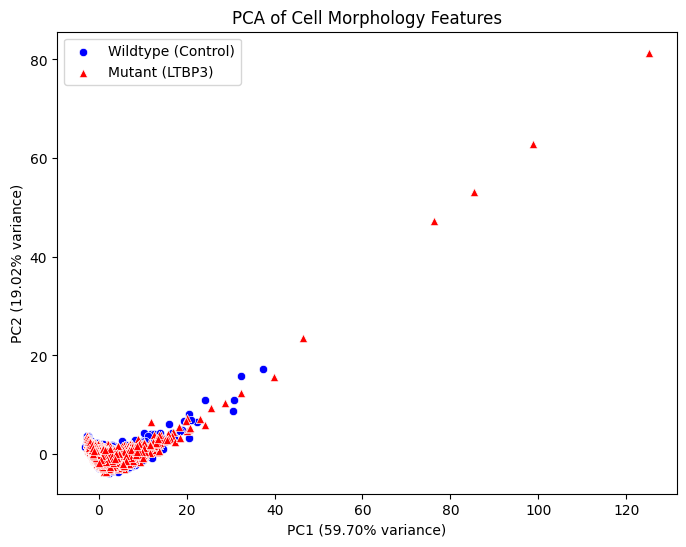

In [3]:
# Prepare data for PCA
X = df_features[features]
y = df_features['condition']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA (2 components for plotting)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['condition'] = y.values

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca[df_pca['condition'] == 'wildtype'], x='PC1', y='PC2', color='blue', marker='o', label='Wildtype (Control)')
sns.scatterplot(data=df_pca[df_pca['condition'] == 'mutant'], x='PC1', y='PC2', color='red', marker='^', label='Mutant (LTBP3)')
plt.title('PCA of Cell Morphology Features')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()
plt.show()

## 2. Violin Plots of Features with P-Values

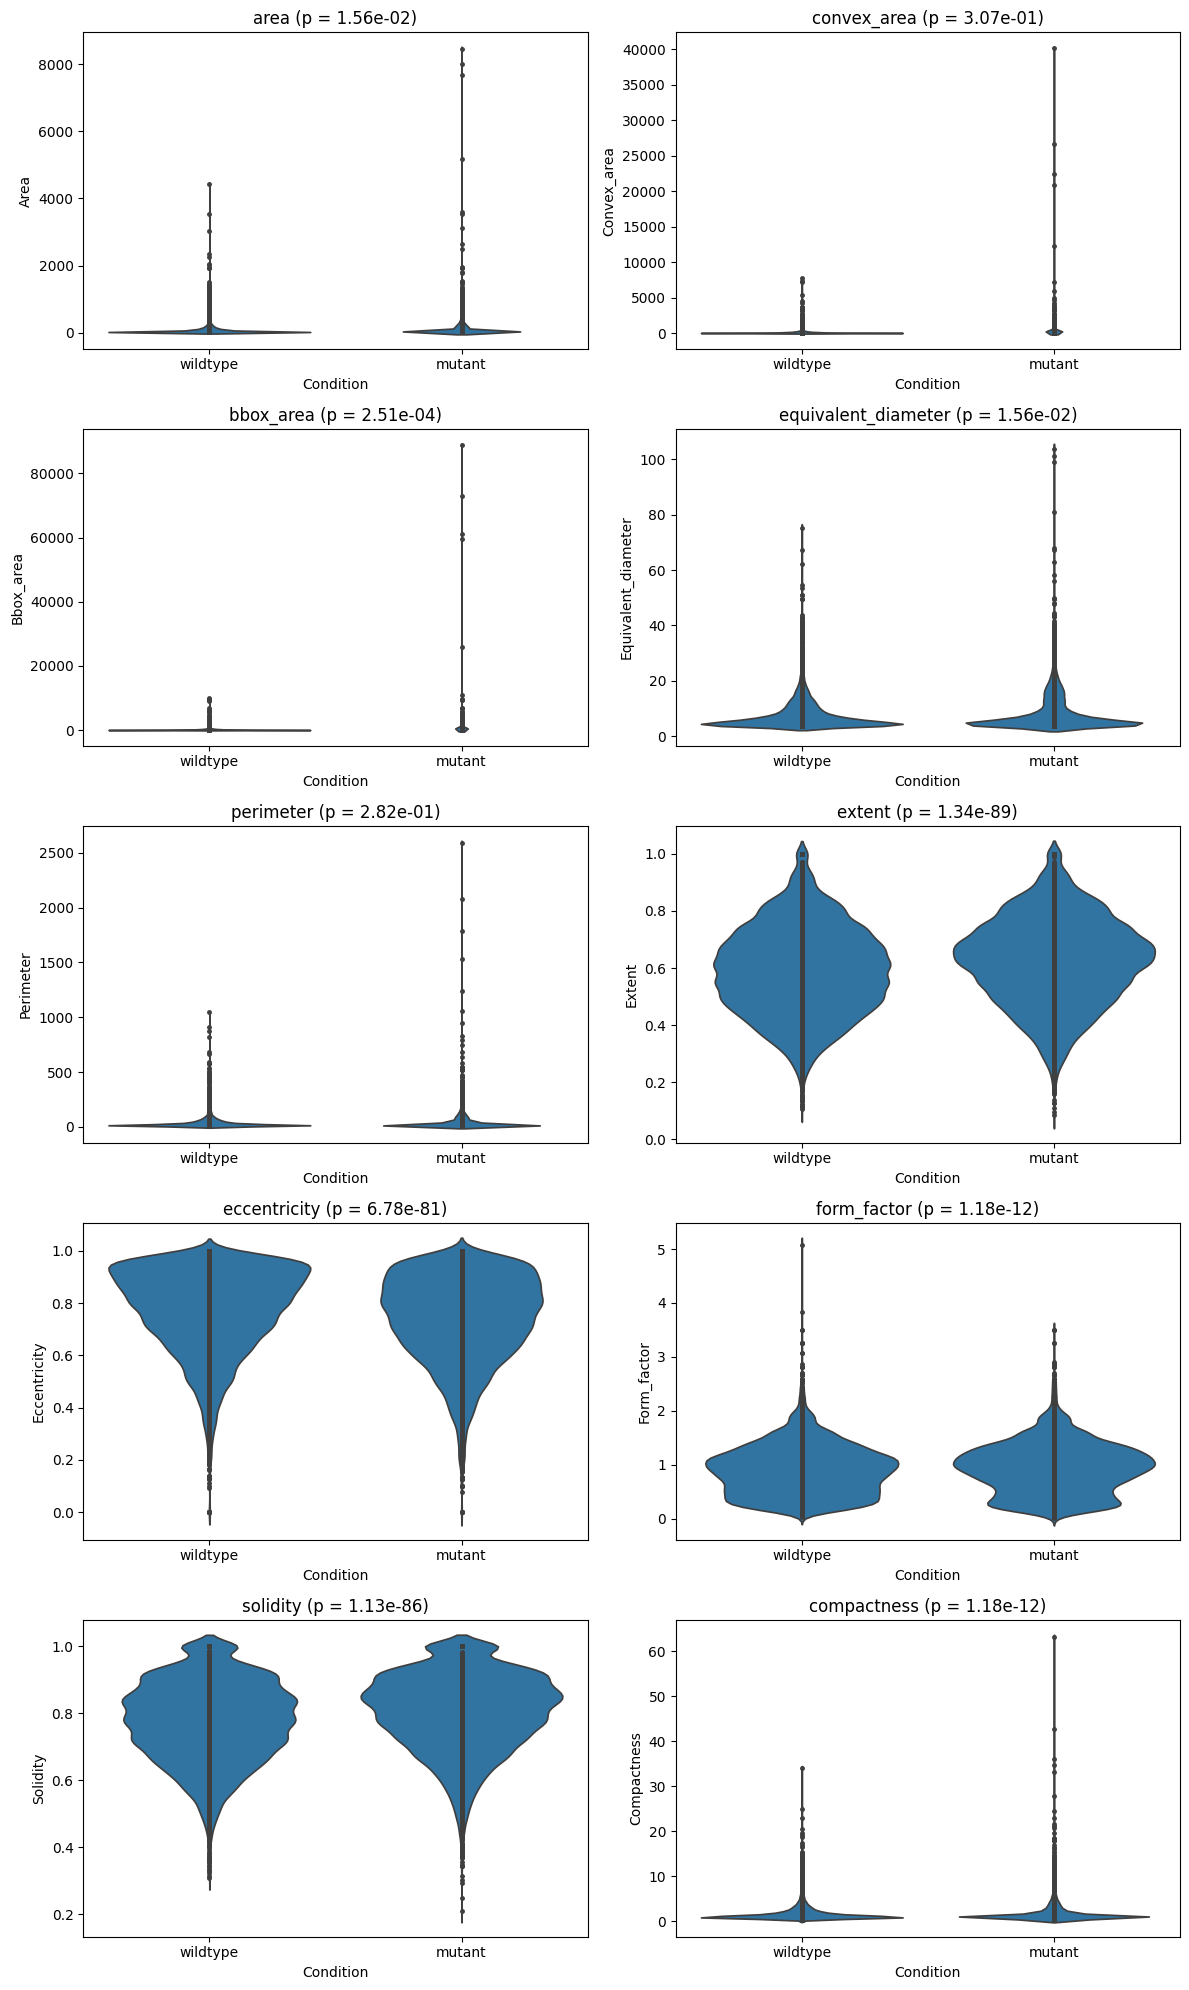

In [4]:
# Function to compute p-value (Mann-Whitney U test)
def compute_p_value(feature):
    wild = df_features[df_features['condition'] == 'wildtype'][feature]
    mut = df_features[df_features['condition'] == 'mutant'][feature]
    stat, p = mannwhitneyu(wild, mut)
    return p

# Plot violin plots for each feature
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
axes = axes.flatten()

for i, feature in enumerate(features):
    p = compute_p_value(feature)
    sns.violinplot(data=df_features, x='condition', y=feature, ax=axes[i], inner='point')
    axes[i].set_title(f'{feature} (p = {p:.2e})')
    axes[i].set_xlabel('Condition')
    axes[i].set_ylabel(feature.capitalize())

plt.tight_layout()
plt.show()